In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/DAP ABSA (1)"

/content/drive/.shortcut-targets-by-id/1KuJ0gMvX7f2ucu8bxFB6lBNphMERr0jU/DAP ABSA


In [ ]:
from transformers import BertModel
from transformers import get_scheduler

import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import os
from tqdm import tqdm

from transformers import BertModel
from transformers import get_scheduler

import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
class ABSADataset_MTL(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length  # Limit sequence length to 512

    def __getitem__(self, idx):
        # return the values of token, tags, pol which for the row at idx as str data
        tokens, tags, pols = self.df.loc[idx, ['Words', 'Tags', 'Polarities']].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')

        bert_tokens = []
        bert_tags = []
        bert_pols = []
        pols_label = 0

        for i in range(len(tokens)):
            t = self.tokenizer.tokenize(tokens[i]) # we tokenize each word in the token list
            bert_tokens += t
            # these two steps ensure that the bert_tags is the same length as the bert_tokens list
            bert_tags += [int(tags[i])] * len(t)
            bert_pols += [int(pols[i])] * len(t) #change labels from [-1-2] -> [0-3]

        # Truncate if exceeding max_length
        if len(bert_tokens) > self.max_length - 2:  # Account for [CLS] & [SEP]
            bert_tokens = bert_tokens[:self.max_length - 2]
            bert_tags = bert_tags[:self.max_length - 2]
            bert_pols = bert_pols[:self.max_length - 2]

        # Add special tokens [CLS] and [SEP]
        bert_tokens = ["[CLS]"] + bert_tokens + ["[SEP]"]
        bert_tags = [0] + bert_tags + [0]  # Padding with neutral tag
        bert_pols = [0] + bert_pols + [0]  # Padding with neutral polarity

        # Convert tokens to IDs
        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        # Convert lists to tensors
        ids_tensor = torch.tensor(bert_ids, dtype=torch.long)
        tags_tensor = torch.tensor(bert_tags, dtype=torch.long)
        pols_tensor = torch.tensor(bert_pols, dtype=torch.long)

        return bert_tokens, ids_tensor, tags_tensor, pols_tensor



    def __len__(self):
        return len(self.df)


class ABSABert_MTL(torch.nn.Module):
    def __init__(self, pretrain_model, adapter=True):
        super(ABSABert_MTL, self).__init__()
        self.adapter = adapter
        #removed the adapter functionality of the model as cannot import bertadaptermodel
        # if adapter:
        #     from transformers.adapters import BertAdapterModel
        #     self.bert = BertAdapterModel.from_pretrained(pretrain_model)
        self.bert = BertModel.from_pretrained(pretrain_model)
        self.abte_head = torch.nn.Linear(self.bert.config.hidden_size, 2) #2 classes for 0,1 (None, Aspect)
        self.absa_head = torch.nn.Linear(self.bert.config.hidden_size, 4) #3 classes for 0,1,2,3 (None, Neg, Neu, Pos)


    def forward(self, ids_tensors, masks_tensors, segments_tensors = None):
        out_dict = self.bert(input_ids=ids_tensors, attention_mask=masks_tensors)
        bert_outputs = out_dict['last_hidden_state']
        abte_outputs = self.abte_head(bert_outputs)
        absa_outputs = self.absa_head(bert_outputs)
        return abte_outputs, absa_outputs


class ABSAModel_MTL ():
    def __init__(self, tokenizer, adapter=True):
        self.model = ABSABert_MTL('bert-base-uncased', adapter=adapter)
        self.tokenizer = tokenizer
        self.trained = False
        self.adapter = adapter

    def padding(self, samples): #nothing to change here as we are just ensuring the sequence lengths are the same

        #bert_tokens, ids_tensor_abte, ids_tensor_absa, tags_tensor, pols_tensor, segment_tensor

        from torch.nn.utils.rnn import pad_sequence
        # Here s[0] for s in samples is the bert_tokens as defined in the __getitem__ method defined above
        ids_tensors_abte = [s[1] for s in samples]
        ids_tensors_abte = pad_sequence(ids_tensors_abte, batch_first=True)
        # batch_first = True retunrs tensor in the shape of B x T x * where T is the longest sequence in the batch and B is the batch size
        # otherwise return in the shape of T x B x *

        tags_tensors = [s[2] for s in samples]
        tags_tensors = pad_sequence(tags_tensors, batch_first=True)

        pols_tensors = [s[3] for s in samples]
        pols_tensors = pad_sequence(pols_tensors, batch_first=True)

        masks_tensors_abte = torch.zeros(ids_tensors_abte.shape, dtype=torch.long)
        masks_tensors_abte = masks_tensors_abte.masked_fill(ids_tensors_abte != 0, 1) #this sets all real tokens to 1 and all padding to zero

        return ids_tensors_abte, tags_tensors, pols_tensors, masks_tensors_abte

    def loss_func(self, abte_logits, absa_logits, labels_abte, labels_absa):
        criterion = torch.nn.CrossEntropyLoss()

        labels_abte = labels_abte.view(-1)
        abte_logits = abte_logits.view(-1,2)
        labels_absa = labels_absa.view(-1)
        absa_logits = absa_logits.view(-1,4)

        lossABTE = criterion(abte_logits, labels_abte)
        lossABSA = criterion(absa_logits, labels_absa)

        return lossABTE+lossABSA

    def load_model(self, model, path):
        model.load_state_dict(torch.load(path), strict=False)

    def save_model(self, model, name):
        torch.save(model.state_dict(), name)

    def train(self, data, epochs, device, path, batch_size=32, lr=1e-5, load_model=None, lr_schedule=True):

        #load model if lead_model is not None
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
                self.trained = True
            else:
                print("lead_model not found")

        # dataset and loader
        ds = ABSADataset_MTL(data, self.tokenizer)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=self.padding)

        self.model = self.model.to(device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr) #optimzier takes in model parameters and learning rate as arg
        num_training_steps = epochs * len(loader)
        if lr_schedule: lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

        self.losses = []

        all_data = len(loader)-1
        for epoch in range(epochs):
            finish_data = 0
            current_times = []
            n_batches = int(len(data)/batch_size)

            if self.adapter:
                if lr_schedule: dir_name  = path + "_" + "model_ABTE_MTL_adapter_scheduler"
                else: dir_name = path + "_" + "model_ABTE_MTL_adapter"
            else:
                if lr_schedule: dir_name  = path + "_" + "model_ABTE_MTL_scheduler"
                else: dir_name = path + "_" + "model_ABTE_MTL"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)

            for nb in range((n_batches)):
                t0 = time.time()

                # ids_tensors, tags_tensors, _, masks_tensors = next(iter(loader))
                # ids_tensor = ids_tensors.to(device)
                # tags_tensor = tags_tensors.to(device)
                # masks_tensor = masks_tensors.to(device)

                # Fetch a batch
                ids_tensors_abte, tags_tensors, pols_tensors, masks_tensors_abte = next(iter(loader))

                # Move tensors to the appropriate device
                ids_tensors_abte = ids_tensors_abte.to(device)
                tags_tensors = tags_tensors.to(device)
                pols_tensors = pols_tensors.to(device)
                masks_tensors_abte = masks_tensors_abte.to(device)

                abte_outputs, absa_outputs = self.model(ids_tensors=ids_tensors_abte, masks_tensors=masks_tensors_abte)

                loss = self.loss_func(abte_outputs, absa_outputs, tags_tensors, pols_tensors)
                self.losses.append(loss.item()) #loss item returns the scalar value of the loss object
                loss.backward()
                optimizer.step()
                if lr_schedule: lr_scheduler.step()
                optimizer.zero_grad()

                finish_data += 1
                current_time = round(time.time() - t0,3)
                current_times.append(current_time)
                print("epoch: {}\tbatch: {}/{}\tloss: {}\tbatch time: {}\ttotal time: {}"\
                    .format(epoch, finish_data, all_data, loss.item(), current_time, sum(current_times)))

                np.savetxt('{}/losses_lr{}_epochs{}_batch{}.txt'.format(dir_name, lr, epochs, batch_size), self.losses)

            self.save_model(self.model, '{}/model_lr{}_epochs{}_batch{}.pkl'.format(dir_name, lr, epoch, batch_size))
            self.trained = True

    def history (self):
        if self.trained:
            return self.losses
        else:
            raise Exception('Model not trained')

    def predict(self, sentence, load_model=None, device='cpu'):
         # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        # word_pieces = list(self.tokenizer.tokenize(sentence))
        # ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        # input_tensor = torch.tensor([ids]).to(device)

        MAX_LEN = 512
        word_pieces = self.tokenizer.tokenize(sentence)
        if len(word_pieces) > MAX_LEN-2:
            word_pieces = word_pieces[:MAX_LEN-2]

        word_pieces = ["[CLS]"] + word_pieces + ["[SEP]"]
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(device)


        #predict
        with torch.no_grad():
            abte_outputs, absa_outputs = self.model(input_tensor, None) #plug token ids into bert model
            _, predictions_abte = torch.max(abte_outputs, dim=2)
            _, predictions_absa = torch.max(absa_outputs, dim=2)
            # dim parameter = 0 operates at batch level, dim = 1 operates at sequence level, dim = 2 operates at token level
            # Since we are identifying aspects and their polarities here we will look at dim = 2

        predictions_abte = predictions_abte[0].tolist()
        predictions_absa = predictions_absa[0].tolist()

        return word_pieces, predictions_abte, predictions_absa, abte_outputs, absa_outputs

    def predict_batch(self, data, load_model=None, device='cpu'):

        tags_real = [t.strip('][').split(', ') for t in data['Tags']]
        tags_real = [[int(i) for i in t ] for t in tags_real]

        polarity_real = [t.strip('][').split(', ') for t in data['Polarities']]
        polarity_real = [[int(i) for i in p ] for p in polarity_real]
        # if -1 is not an aspect term, if 0 negative, if 2 positive, if 1 neutral, shift of 1
        """ Class labels start at 0 (important for ML models like CrossEntropyLoss on pytorch).
            -1 (not an aspect term) is converted to None to be ignored. The model receives
            properly formatted class labels. """
        # polarity_real = [[int(i)+1 for i in t] for t in polarity_real] old code

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        predictions_abte = []
        predictions_absa = []

        for i in tqdm(range(len(data))):
            sentence = data['Words'][i]
            sentence = sentence.replace("'", "").strip("][").split(', ')
            sentence = ' '.join(sentence) #this converts the list back into a clean sentence
            w, p_abte, p_absa, _, _ = self.predict(sentence, load_model=load_model, device=device)
            predictions_abte.append(p_abte)
            predictions_absa.append(p_absa)
            tags_real[i] = tags_real[i][:len(p_abte)]
            polarity_real[i] = polarity_real[i][:len(p_absa)]

        return predictions_abte, predictions_absa, tags_real, polarity_real

    def _accuracy (self, x,y):
        return np.mean(np.array(x) == np.array(y))

    def test(self, dataset, load_model=None, device='cpu'): # device = 'cpu'
        from sklearn.metrics import classification_report
        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

         # dataset and loader
        ds = ABSADataset_MTL(dataset, self.tokenizer)
        loader = DataLoader(ds, batch_size=50, shuffle=True, collate_fn=self.padding)

        pred_abte = []#padded list
        trueth_abte = [] #padded list
        pred_absa = []#padded list
        trueth_absa = [] #padded list
        with torch.no_grad(): # disables gradient calculations to save computaional memory
            for data in tqdm(loader): #tqdm takes in a iterable to show the progress

                # ids_tensors, tags_tensors, _, masks_tensors = data
                # ids_tensors = ids_tensors.to(device)
                # tags_tensors = tags_tensors.to(device)
                # masks_tensors = masks_tensors.to(device)
                ids_tensors, tags_tensors_abte, pols_tensors_absa, masks_tensors = data
                ids_tensors = ids_tensors.to(device)
                tags_tensors_abte = tags_tensors_abte.to(device)
                pols_tensors_absa = pols_tensors_absa.to(device)
                masks_tensors = masks_tensors.to(device)

                # outputs = self.model(ids_tensors=ids_tensors, masks_tensors=masks_tensors)
                abte_outputs, absa_outputs = self.model(ids_tensors=ids_tensors, masks_tensors=masks_tensors)

                _, p_abte = torch.max(abte_outputs, dim=2) #return the aspect class with the highest probability
                _, p_absa = torch.max(absa_outputs, dim=2) #return the polarity class with the highest probability

                # pred += list([int(j) for i in p for j in i ])
                # trueth += list([int(j) for i in tags_tensors for j in i ])

                #Flattens predictions (p_abte) and true labels (tags_tensors_abte) into lists, do the same for p_absa and pols_tensor_absa:
                pred_abte += [int(j) for i in p_abte for j in i]
                trueth_abte += [int(j) for i in tags_tensors_abte for j in i]

                pred_absa += [int(j) for i in p_absa for j in i]
                trueth_absa += [int(j) for i in pols_tensors_absa for j in i]

        # acc = self._accuracy(pred, trueth)
        # class_report = classification_report(trueth, pred, target_names=['none', 'start of AT', 'mark of AT'])

        acc_abte = self._accuracy(pred_abte, trueth_abte)
        class_report_abte = classification_report(trueth_abte, pred_abte, target_names=['none', 'AT'])

        acc_absa = self._accuracy(pred_absa, trueth_absa)
        class_report_absa = classification_report(trueth_absa, pred_absa, target_names=['none', 'negative', 'neutral', 'positive'])

        return acc_abte, class_report_abte, acc_absa, class_report_absa

    def accuracy(self, data, load_model=None, device='cpu'): #kinda useless function as it js calls self.test
      # def accuracy(self, data, load_model=None, device='cpu'):
        abte_acc, _, absa_acc, _  = self.test(data, load_model=load_model, device=device)
        return abte_acc, absa_acc

In [ ]:
def update_index(df):
  df['id'] = df['id'].astype(str)
  i = 0
  prev_id = float(df.loc[i, 'id'])
  for j in range(len(df)):
    id = float(df.loc[j, 'id'])
    if(id < prev_id):
      print("test")
      i += 1
    df.loc[j,'id'] = df.loc[j,'id'] + f'_{i}'
    prev_id = id


def find_sublist_indices(lst, sublst, start = 0):
    for i in range(start,len(lst) - len(sublst) + 1):
        if lst[i:i+len(sublst)] == sublst:
            return i  # Return the start index of the match
    return -1  # Not found

def to_token(tokenizer, sentence):
    MAX_LEN = 512
    word_pieces = tokenizer.tokenize(sentence)
    # aspect = tokenizer.tokenize(aspect)
    if len(word_pieces) > MAX_LEN-2:
        word_pieces = word_pieces[:MAX_LEN-2]

    word_pieces = ["[CLS]"] + word_pieces + ["[SEP]"]
    return word_pieces

def word_to_tag(tags, sentence, aspect, polarity, starting_index):
    polarity_tags = [-1]*len(sentence)
    aspect_list = aspect.split(" ")
    sub_len = len(aspect_list)
    ending_index = 0
    for i in range(starting_index, len(sentence) - sub_len + 1):
        if sentence[i:i + sub_len] == aspect_list:
            tags[i] = 1
            if polarity == 'negative':
                polarity_tags[i] = 0
                polarity = 0
            elif polarity == 'neutral':
                polarity_tags[i] = 1
                polarity = 1
            else:
                polarity_tags[i] = 2
                polarity = 2
            for j in range(1, len(aspect_list)):
                tags[i+j] = 2
                polarity_tags[i+j] = polarity
                ending_index = i+j
            break
    return tags, polarity_tags, ending_index


def word_to_tag_tokenize(tags, sentence, aspect_list, polarity, starting_index):
    polarity_tags = [-1]*len(sentence)
    sub_len = len(aspect_list)
    ending_index = 0
    for i in range(max(1, starting_index), len(sentence) - sub_len + 1):
        if sentence[i:i + sub_len] == aspect_list:
            tags[i] = 1
            if polarity == 'negative':
                polarity_tags[i] = 0
                polarity = 0
            elif polarity == 'neutral':
                polarity_tags[i] = 1
                polarity = 1
            else:
                polarity_tags[i] = 2
                polarity = 2
            for j in range(1, len(aspect_list)):
                tags[i+j] = 2
                polarity_tags[i+j] = polarity
                ending_index = i+j
            break
    return tags, polarity_tags, ending_index

def word_to_tag_df_tokenize(df, tokenizer):
    previous_id = 0
    sentence = df.iloc[0]['words']
    sentence = sentence.replace("'", "").strip("][").split(', ')
    sentence = ' '.join(sentence)
    word_pieces = to_token(tokenizer,sentence)
    tags = [0]*len(word_pieces)
    starting_index = 0
    starting_aspect = df.loc[0]['aspect']
    for i in range(len(df)):
        sentence = df.iloc[i]['words']
        sentence = sentence.replace("'", "").strip("][").split(', ')
        sentence = ' '.join(sentence)
        word_pieces = to_token(tokenizer,sentence)
        id = df.iloc[i]['id']
        aspect = df.iloc[i]['aspect']
        #add tags into the dataframe, and reset starting_index and tags if is a new id
        if (id != previous_id):
            for j in df[df['id'] == previous_id].index.tolist():
                df.loc[j,'Tags'] = str(tags)
            starting_index = 0
            tags = [0]*len(word_pieces)
            previous_id = id

        #reset starting index when it is a new aspect
        if (starting_aspect != aspect):
          starting_index = 0
          starting_aspect = aspect

        aspect_token = tokenizer.tokenize(aspect)
        df.loc[i,'aspect_token'] = str(aspect_token)
        df.loc[i, 'words_token'] = str(word_pieces)
        tags,polarity_tag,ending_index = word_to_tag_tokenize(tags,word_pieces,aspect_token,df.iloc[i]['polarity'],starting_index)
        starting_index = ending_index
        df.loc[i,'Polarities'] = str(polarity_tag)

    #adding tags to the last entry in the dataframe
    id = df.iloc[len(df)-1]['id']
    for j in df[df['id'] == id].index.tolist():
        df.loc[j,'Tags'] = str(tags)




def tag_to_word(sentence, predictions):
    """
    predictions: list of tags
    sentence: list of words
    """
    terms = []
    for i, word in enumerate(sentence):
        w = None
        if predictions[i] == 1:
            w = word
            for j in range(i+1, len(sentence)):
                if predictions[j] == 2:
                    w += ' ' + sentence[j]
                else:
                    terms.append(w)
                    i = j
                    break

    return terms

def tag_to_word_df(df, column_name, tags):
    """
    predictions: list of tags
    sentence: list of words
    """
    terms_list = []
    for i in range(len(df)):
        sentence = df.iloc[i]['words_token']
        sentence = sentence.replace("'", "").strip("][").split(', ')
        terms = tag_to_word(sentence, tags[i])
        terms_list.append(terms)
    df[column_name] = terms_list
    return df

def tag_to_pol(sentence, predictions_abte, predictions_absa):
    """
    predictions: list of tags
    sentence: list of words
    """
    terms_pol = {}
    for i, word in enumerate(sentence):
        w = None
        if predictions_abte[i] == 1:
            pol_map = {1:'negative', 2:'neutral',3:'positive'}
            p = pol_map[predictions_absa[i]]
            w = word
            for j in range(i+1, len(sentence)):
                if predictions_abte[j] == 1:
                    w += ' ' + sentence[j]
                else:
                    terms_pol[w] = p
                    i = j
                    break

    return terms_pol

def classification_report_read(report_path):
    """
    Read classification report from file
    """

    with open(report_path, 'r') as f:
        report = f.read()
    return report

def print_aligned(report1, report2, title1, title2):
    """
    print two classification report aligned to the columns
    """
    print (1*'\t', title1, 6*'\t', title2)
    report1 = report1.split('\n')
    report2 = report2.split('\n')
    for r1, r2 in zip(report1, report2):
        print(r1, '\t\t', r2)


In [ ]:
# Step 1: Ensure imports and environment setup
import os, sys
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")

## Add `/content/` to system path to access abte.py
# sys.path.insert(1, '/content/')

# Step 2: Load the dataset from Colab storage
dataset_path = "Combined_Train_MTL.csv"
data = pd.read_csv(dataset_path)

# Step 3: Initialize tokenizer and device
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")


# Step 4: Import and initialize the ABTE model
modelABSA_MTL = ABSAModel_MTL(tokenizer, adapter=False)  # Set adapter=True if needed
modelABSA_MTL.model.to(DEVICE)

# Step 5: Define training parameters
batch_size = 8
epochs = 5
lr = 3e-5
lr_schedule = True

# # Step 6: Train the model
# modelABSA_MTL.train(
#     data,
#     batch_size=batch_size,
#     lr=lr,
#     epochs=epochs,
#     path = "new_data",
#     device=DEVICE,
#     lr_schedule=lr_schedule
# )

print("✅ Training complete!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Training complete!


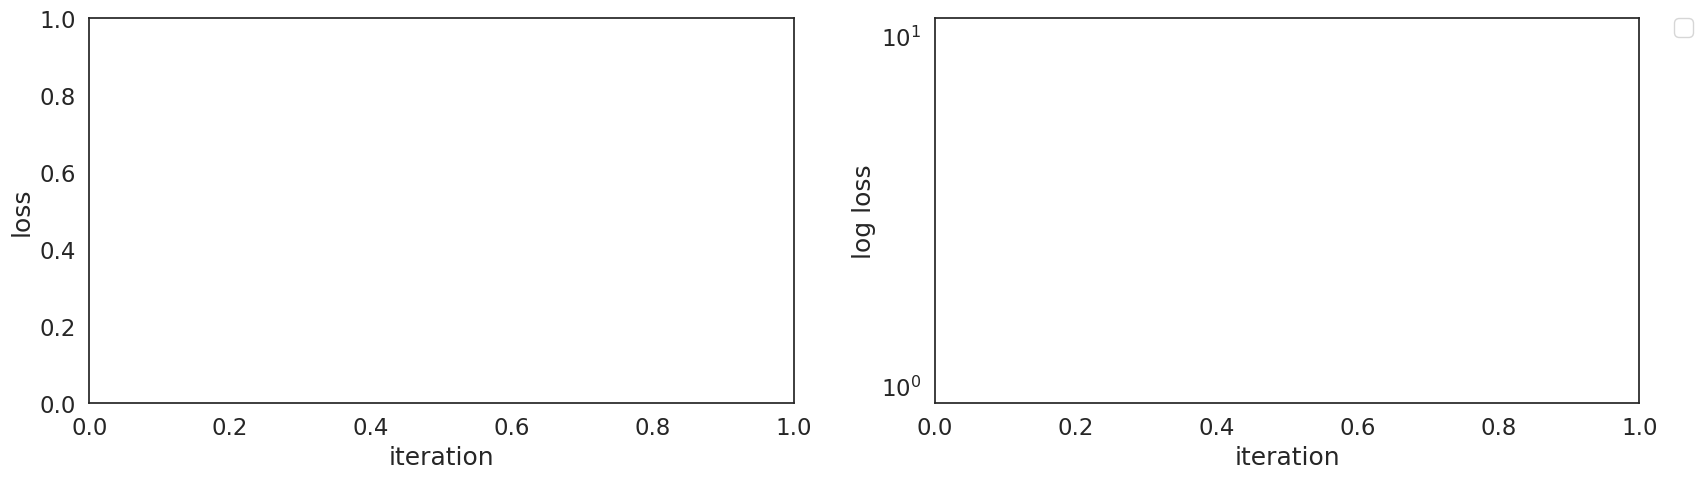

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

batch = 8
epochs = 3
lr = 3e-5

lossABTE = np.loadtxt("new_data_model_ABTE_MTL_scheduler/losses_lr3e-05_epochs5_batch8.txt")

sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5, palette="Dark2")
fig, ax = plt.subplots(1,2,figsize=(20,5))

for i in [0,1]:
    sns.lineplot(x=list(range(len(lossABTE))), y=lossABTE, ax=ax[i], label = 'Fine tuning')
    # sns.lineplot(range(len(lossABTE_S)), lossABTE_S, ax=ax[i], label = 'Fine tuning +\nscheduler')
    # sns.lineplot(range(len(lossABTE_A)), lossABTE_A, ax=ax[i], label = 'Adapter')
    # sns.lineplot(range(len(lossABTE_AS)), lossABTE_AS, ax=ax[i], label = 'Adapter +\nscheduler')

    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('loss')
ax[1].set_yscale('log')
ax[1].set_ylabel('log loss')
ax[0].legend().set_visible(False)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

dir = 'results_ABTE_MTL_new_data'
if not os.path.isdir(dir):
    os.makedirs(dir)

fig.savefig(dir+'/loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
#Test the model on sample sentence
abte_model_path = 'new_data_model_ABTE_MTL_scheduler/model_lr3e-05_epochs4_batch8.pkl'
sentence = "I love alcohol but it is ruining my life my therapist is helping me get better"
sentence = sentence.split(' ')
sentence = ' '.join(sentence)

word_pieces, predictions_abte, predictions_absa, abte_outputs, absa_outputs = modelABSA_MTL.predict(sentence, load_model=abte_model_path, device=DEVICE)
print(word_pieces)
print(predictions_abte)
terms = tag_to_word(word_pieces, predictions_abte)
print(predictions_absa)

['[CLS]', 'i', 'love', 'alcohol', 'but', 'it', 'is', 'ruining', 'my', 'life', 'my', 'therapist', 'is', 'helping', 'me', 'get', 'better', '[SEP]']
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 3, 0]


In [ ]:
print(word_pieces)
print(predictions_abte)
pol_terms = tag_to_pol(word_pieces, predictions_abte, predictions_absa)
pol_terms

['[CLS]', 'i', 'love', 'alcohol', 'but', 'it', 'is', 'ruining', 'my', 'life', 'my', 'therapist', 'is', 'helping', 'me', 'get', 'better', '[SEP]']
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]


{'alcohol': 'negative', 'life': 'negative', 'therapist': 'positive'}

In [ ]:
test_data = pd.read_csv("Combined_Test_MTL.csv")
# data = pd.read_csv("Combined_Train_MTL.csv")

dir_name = 'new_data_model_ABTE_MTL_scheduler'

#save results
if not os.path.exists(dir_name+'/results'):
  os.makedirs(dir_name+'/results')

#report
model_path = 'new_data_model_ABTE_MTL_scheduler/model_lr3e-05_epochs4_batch8.pkl'
test_acc_abte, test_report_abte, test_acc_absa, test_report_absa = modelABSA_MTL.test(test_data, load_model=model_path, device=DEVICE)
test_predictions_abte, test_predictions_absa, test_tags_real, test_polarity_real = modelABSA_MTL.predict_batch(test_data, load_model=model_path, device=DEVICE)


with open(dir_name+'/results/test_report_abte_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
  for r in test_report_abte.split('\n'):
      f.write(r + '\n')

with open(dir_name+'/results/test_report_absa_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
  for r in test_report_absa.split('\n'):
      f.write(r + '\n')


# train_acc_abte, train_report_abte, train_acc_absa, train_report_absa = modelABSA_MTL.test(data, load_model=model_path, device=DEVICE)
# train_predictions_abte, train_predictions_absa, train_tags_real, train_polarity_real = modelABSA_MTL.predict_batch(data, load_model=model_path, device=DEVICE)


# with open(dir_name+'/results/train_report_abte_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
#   for r in train_report_abte.split('\n'):
#       f.write(r + '\n')

# with open(dir_name+'/results/train_report_absa_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
#   for r in train_report_absa.split('\n'):
#       f.write(r + '\n')

#predictions
test_data['Predicted_ABTE'] = test_predictions_abte
test_data['Actual_ABTE'] = test_tags_real
test_data['Predicted_ABSA'] = test_predictions_absa
test_data['Actual_ABSA'] = test_polarity_real
test_data.to_csv(dir_name+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

# data['Predicted_ABTE'] = train_predictions_abte
# data['Actual_ABTE'] = train_tags_real
# data['Predicted_ABSA'] = train_predictions_absa
# data['Actual_ABSA'] = train_polarity_real
# data.to_csv(dir_name+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

#accuracy
test_acc_abte = np.array(test_acc_abte)
test_acc_absa = np.array(test_acc_absa)
# train_acc_abte = np.array(train_acc_abte)
# train_acc_absa = np.array(train_acc_absa)

with open(dir_name+'/results/test_accuracy_abte_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
  f.write(str(test_acc_abte))
with open(dir_name+'/results/test_accuracy_absa_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
  f.write(str(test_acc_absa))

# with open(dir_name+'/results/train_accuracy_abte_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
#   f.write(str(train_acc_abte))
# with open(dir_name+'/results/train_accuracy_absa_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
#   f.write(str(train_acc_absa))

100%|██████████| 1803/1803 [15:46<00:00,  1.90it/s]


In [ ]:
#change the filepaths accordingly
test_ABTE = classification_report_read(dir_name+'/results/test_report_abte_lr3e-05_epochs5_batch8.csv')
# train_ABTE = classification_report_read(dir_name+'/results/train_report_abte_lr3e-05_epochs5_batch8.csv')
test_ABSA = classification_report_read(dir_name+'/results/test_report_absa_lr3e-05_epochs5_batch8.csv')
# train_ABSA = classification_report_read(dir_name+'/results/train_report_absa_lr3e-05_epochs5_batch8.csv')
# print_aligned(test_ABTE, train_ABTE, 'TEST FINE-TUNING', 'TRAIN FINE-TUNING')
# print_aligned(test_ABTE, test_ABSA, 'TEST FINE-TUNING', 'TRAIN FINE-TUNING')
print_aligned(test_ABTE, test_ABSA, 'ABTE TEST FINE-TUNING', 'ABSA TEST FINE-TUNING')

	 ABTE TEST FINE-TUNING 						 ABSA TEST FINE-TUNING
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
        none       0.98      0.99      0.99    885467 		         none       0.98      0.99      0.99    885467
          AT       0.65      0.51      0.57     33469 		     negative       0.56      0.41      0.47     20804
 		      neutral       0.43      0.36      0.39      7061
    accuracy                           0.97    918936 		     positive       0.46      0.32      0.38      5604
   macro avg       0.81      0.75      0.78    918936 		 
weighted avg       0.97      0.97      0.97    918936 		     accuracy                           0.97    918936
 		    macro avg       0.61      0.52      0.56    918936
 		 weighted avg       0.96      0.97      0.97    918936
